<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-m1-mini-project/blob/rajiv-playpen/M1_MP1_NB_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A Program by IISc and TalentSprint

### Mini Project Notebook 2: Hypothesis Testing

## Learning Objectives



At the end of this Mini Project, you will be able to :


* have a fair understanding of A/B Testing - a statistical way to compare two or more versions (A or B?)

* determine not only which one (A or B) performs better but also understand if the difference between two of them is statistically significant

* derive meaningful insights from the formula for Confidence Intervals with the t-distribution and how to adjust this formula using the Central Limit Theorem

* know the dependent 3 factors (Power of the test, Significance level & Minimal Desired Effect) for having a required Sample Size

* carry out Binomial Proportion Confidence Intervals, 2-sample Z-test and Chi-square. The objective of this mini project is to serve as an introductory guide to A/B testing, covering foundational concepts and methodologies.


## Introduction

A/B tests are very commonly performed by data analysts and data scientists.

It is a crucial technique in data-driven decision-making, yet it often lacks comprehensive exploration. This notebook aims to address this gap by providing a consolidated overview of A/B testing principles and practices.

For this mini project, the exercises are framed to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new webpage or keep the old webpage or run the experiment longer to make their decision.

## Dataset

The dataset chosen for this experiment is the **ab_data.csv** which is publicly available on [Kaggle](https://www.kaggle.com/datasets/abdelrahmanrezk7/ab-testing-e-commerce-website)  

This dataset consists of 2,94,478 records. Each record is made up of 5 fields.

**For example**, Each record consists of 'user_id', 'timestamp', 'group', 'landing_page' and 'converted'.

* **user_id:** A unique identifier assigned to each user (i.e., a visitor to the company's webpage) participating in the experiment.

* **timestamp:** The timestamp indicating the time at which the user interacted with the webpage or was exposed to the experimental condition.

* **group:** The group to which the user was assigned, typically denoted as either 'treatment' or 'control'. This field helps categorize users into different experimental conditions.

* **landing_page:** Specifies the type of landing page or webpage variant that the user was directed to upon interaction. It distinguishes between different versions of the webpage used in the experiment.

* **converted:** A binary indicator representing whether the user performed the desired action or conversion after interacting with the webpage. It typically indicates whether the user made a purchase, signed up for a service, or completed any other desired action.

## Problem Statement

The biggest e-commerce company called **FaceZonGoogAppFlix** approached to a **data science consulting** firm as a new client!

They have a potential new webpage designed with the intention to increase their current conversion rates of 12% by 0.35% or more. With such an ambiguous task, they have full trust in the data science consulting firm to give them a recommendation whether to implement the new web page or keep the old webpage. Unfortunately they haven't built up a data science capability in their company, but they've used an external software called 'A/B Tester' for 23 days and then come back to the data science consulting firm with a dataset (ab_data.csv). Under this requirement scenario, what the **data science consulting firm** will do?

## Grading = 10 Points

In [1]:
# @title Download the Dataset
! wget -q https://cdn.exec.talentsprint.com/static/cds/content/ab_data.csv
print("The datset was downloaded successfully")


The datset was downloaded successfully


# **Part I - Probability**

#### Import required packages

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import math as mt
import itertools
import random
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline



#### Load the dataset

In [4]:
# a. Read in the dataset and take a look at the top few rows here:
# YOUR CODE HERE

df = pd.read_csv("ab_data.csv")
df.head(5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [43]:
df.tail(5)


,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [44]:
# b. Use the below cell to find the number of rows in the dataset.
# YOUR CODE HERE
total_rows=df.shape[0]
print(f"number of rows are: {total_rows}")


number of rows are: 294478


## Pre-processing

### Task 1: Data Cleaning (1 point)

* Check the number of unique users in the dataset

* Check the proportion of users converted.
  
    **Hint:** query(), count()
* Estimate how many times the new_page and treatment don't line up. Also estimate how many times the old_page and control do not match.

* Display the total no. of non-line up pages

* Check if any of the rows have missing values?

#### **Treatment Group & Control Group**
* **Treatment Group (New Webpage):**
Users in this group will be exposed to the new webpage design.
The effectiveness of the new webpage design will be measured by comparing the conversion rates of users (who actually make purchase of the company's products after visiting this new webpage) in this group to those in the control groups.

* **Control Group (Old Webpage):**
Users in this group will be shown a webpage that is already in use and has demonstrated effectiveness in terms of conversion rates. It means that users in Control Group 2 will see the same old webpage that is currently being used. This webpage has been proven to be effective in terms of converting visitors into purchasers (or customers) in the past.

-- This group serves as a benchmark to evaluate whether the new webpage design outperforms the existing treatment.

-- This group (Control Group) acts as a standard for comparison to see if the new webpage design performs better than the current one. We will use the conversion rates observed in Control Group to assess whether the changes made in the new webpage design lead to better results or not.

In [45]:
# c. The number of unique users in the dataset.
# YOUR CODE HERE
unique_row = df["user_id"].nunique(dropna=False)
print(f"unique row are: {unique_row} and repeated rows are: {total_rows-unique_row}")


unique row are: 290584 and repeated rows are: 3894


In [46]:
df.query('converted == 1')['converted'].count() / df.shape[0]


0.11965919355605512

In [47]:
# find the unique values in landing page column
df["landing_page"].unique()


array(['old_page', 'new_page'], dtype=object)

In [48]:
# identify treatment does not match with new_page
# YOUR CODE HERE
misaligned_treatment_rows = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]
misaligned_treatment_rows


1965

In [49]:
# identify control does not match with old_page
# YOUR CODE HERE
misaligned_control_rows = df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].shape[0]
misaligned_control_rows


1928

In [50]:
# Total no. of non-line up
# YOUR CODE HERE
print(f"Total non-line up rows are: {misaligned_treatment_rows+misaligned_control_rows}")


Total non-line up rows are: 3893


In [51]:
# Check for any missing values
# YOUR CODE HERE
df.isna().sum()


,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [52]:
# Check datatype of each column
# YOUR CODE HERE
df.dtypes


,0
user_id,int64
timestamp,object
group,object
landing_page,object
converted,int64


### Task 2: Identify the not aligned rows (1 point)

<u>**Part-2a:**</u>

With the above dataset (achieved in Task-1) the requirement is to first identify the rows in that dataset where the treatment group is aligned with the new_page and where the control group is aligned with the old_page.

**Hint:** It creates a new DataFrame containing these filtered rows.
**('group == "treatment" and landing_page == "new_page"')**

<u>**Part-2b:**</u>

Now, with the help of the new dataset (achieved in Part-2a of Task-2), we need to identify the misaligned rows in the dataset (achieved in Task-1) where treatment is not aligned with new_page or control is not aligned with old_page

This can be done by checking the values 'treatment' and 'control' under the 'group' column to ensure they do not correspond with the values 'new_page' and 'old_page' under the 'landing_page' column, respectively.

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. Write your code to provide how we should handle these rows.

In [53]:
# Part-2a
# create a new dataset that meets the specifications:
# treatment is aligned with new_page or control is aligned with old_page
# YOUR CODE HERE
df_original = df.copy(deep=True)
df = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]


In [54]:
# show the dimension of the new dataset created
# YOUR CODE HERE
df.shape


(290585, 5)

In [55]:
# Part-2b
# Now, with the help of the new dataset (achiebed above), identify the misaligned rows in the dataset (achieved in Task-1)
# where treatment is not aligned with new_page or control is not aligned with old_page
# YOUR CODE HERE
df_ = df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | ((df['group'] == 'control') & (df['landing_page'] != 'old_page'))]


In [56]:
# Double Check all of the correct rows were removed - this should be 0
# YOUR CODE HERE
df_.shape[0]


0

### Task-3: Using the above new dataset, answer the following questions. (1.5 points)

* How many unique user_ids are in the new dataset created above in Task-2?

* There is one user_id repeated in this dataset. What is it? (Here you need to show only the user_id)

* What is the row information for the repeat user_id? (Here, you need to show the complete row including 'user_id', 'timestamp', 'group', 'landing_page' and	'converted')

* Remove one of the rows with a duplicate user_id, but keep your dataframe name as same.

In [57]:
# YOUR CODE HERE
df["user_id"].nunique(dropna=False)


290584

In [58]:
# print the duplicated user_id
# YOUR CODE HERE
df[df["user_id"].duplicated()]["user_id"]


,user_id
2893,773192


In [59]:
# show the row information of the duplicate user_id
# YOUR CODE HERE
dup_indexes = df[df["user_id"].duplicated(keep=False)].index
df[df["user_id"].duplicated(keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [60]:
# drop the duplicate user_id, keep your dataframe name as same.
# YOUR CODE HERE
df.drop_duplicates(subset="user_id",keep='first',inplace=True,ignore_index=True)
df.iloc[dup_indexes]


,user_id,timestamp,group,landing_page,converted
1899,884846,2017-01-10 20:13:29.946221,control,old_page,0
2893,750416,2017-01-05 15:13:34.798940,treatment,new_page,0


## Finding Probabilities

### Task 4: After removing the duplicated user_id, answer the following: (1.5 points)

##### Exercise 1: What is the probability of an individual converting regardless of the page they receive?

In [61]:
# YOUR CODE HERE
pvalue_converted_users = df.query('converted == 1')['converted'].count() / df.shape[0]
print(f"Probability of individual users converted is: {round(pvalue_converted_users*100,4)}%")


Probability of individual users converted is: 11.9597%


##### Exercise 2: Given that an individual was in the control group, what is the probability they converted?

In [62]:
# Probability of converted P(A)
# Probability of user in control group P(B)
# Probability of conversion given in control group P(A|B) = P(A AND B)/P(B)
# YOUR CODE HERE
pvalue_converted_and_control_group = df[(df["group"] == "control") & (df["converted"] == 1)]["converted"].count() / len(df)
pvalue_control_group = df[df["group"] == "control"]["group"].count()/len(df)
pvalue_converted_given_control_group=pvalue_converted_and_control_group/pvalue_control_group
print(f"Probability of individual users converted in the control group is: {round(pvalue_converted_given_control_group*100,4)}%")


Probability of individual users converted in the control group is: 12.0386%


##### Exercise 3: Given that an individual was in the treatment group, what is the probability they converted?

In [63]:
# YOUR CODE HERE
pvalue_converted_given_treatment_group = df.query('group == "treatment"')["converted"].mean()
print(f"Probability of individual users converted in the treatment group is: {round(pvalue_converted_given_treatment_group*100,4)}%")


Probability of individual users converted in the treatment group is: 11.8808%



##### Exercise 4: What is the probability that an individual received the new page?

In [64]:
# YOUR CODE HERE
pvalue_new_page = df.query('landing_page == "new_page"')["landing_page"].count()/len(df)
print(f"Probability of individual users recieving new page: {round(pvalue_new_page*100,4)}%")


Probability of individual users recieving new page: 50.0062%


In [65]:
# What is the probability that an individual received the old page?
# YOUR CODE HERE
pvalue_old_page = 1 - pvalue_new_page
print(f"Probability of individual users recieving new page: {round(pvalue_old_page*100,4)}%")


Probability of individual users recieving new page: 49.9938%


In [66]:
# show the difference: (treatment_convert - control_convert)
# YOUR CODE HERE
print(f"Probability of individual users converted in the treatment group is: {abs(round((pvalue_converted_given_treatment_group-pvalue_converted_given_control_group)*100,4))}%")


Probability of individual users converted in the treatment group is: 0.1578%


##### Exercise 5: Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions? Write your response below.

#### **Write your response here:**

Based on the difference in probabilities of control and treatment conversions we can conclude that there isnt much difference between the conversion rate between treatment and control groups.

# **Part II - A/B Test**

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% (i.e. 0.05), what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.

$$  H_{null} : p_{new} - p_{old} <= 0 $$  

$$  H_{alternative} : p_{new} - p_{old} > 0 $$

2. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in the new dataset achieved at the end of Task-3.

Perform the sampling distribution in the following exercises under Task-5 for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

In [67]:
# YOUR CODE HERE


### Task 5: Derive the below insights (2 points)

* **$n_{old}$** - The number of individuals (each having unique user_id) who received the old page (control group)

* **$n_{new}$** - The Number of individuals (each having unique user_id) who received the new page (treatment group)

* **$p_{new}$ under the null:** This refers to the conversion rate for the new page (treatment group) that we would expect to observe if the null hypothesis ($H_{null}$) is true.
In other words, it represents the probability of conversion for users who are exposed to the new page under the assumption that there is no difference in conversion rates between the old and new pages.

So, basically **$p_{new}$ under the null** is the conversion rate for the new page that we would expect to see if the new page had no impact on user behavior compared to the old page. It serves as a reference point for evaluating the observed conversion rate for the new page in relation to the null hypothesis ($H_{null}$).

* **$p_{old}$ under the null:** This refers to the conversion rate for the old page (control group) that we would expect to observe if the null hypothesis ($H_{null}$) is true.
In other words, it represents the probability of conversion for users who are exposed to the old page under the assumption that there is no difference in conversion rates between the old and new pages.

So, basically **$p_{old}$ under the null** is the conversion rate for the old page that we would expect to see if the old page had no impact on user behavior compared to the new page. It serves as a reference point for evaluating the observed conversion rate for the old page in relation to the null hypothesis ($H_{null}$).

##### Exercise 1: What is the convert rate for $p_{new}$ under the null?

In [68]:
# YOUR CODE HERE
# p_new = pvalue_converted_given_treatment_group
p_new = pvalue_converted_users
p_new


0.11959708724499628

##### Exercise 2: What is the convert rate for $p_{old}$ under the null?



In [69]:
# YOUR CODE HERE
# p_old = pvalue_converted_given_control_group
p_old = pvalue_converted_users
p_old


0.11959708724499628

##### Exercise 3: What is $n_{new}$?

In [70]:
# YOUR CODE HERE
n_new = df.query('group == "treatment"')["group"].count()
print(f"{n_new}")


145310


##### Exercise 4: What is $n_{old}$?

In [71]:
# YOUR CODE HERE
n_old = df.query('group == "control"')["group"].count()
print(f"{n_old}")


145274


this one was tricky. But here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

##### Exercise 5: Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in **new_page_converted**.

**Hint:** Use **np.random.binomial()**

In [72]:
#np.random.binomial?


In [73]:
# YOUR CODE HERE
new_page_converted = np.random.binomial(n=1,p=p_new,size=n_new)
new_page_converted


array([0, 0, 0, ..., 0, 0, 0])

##### Exercise 6: Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [74]:
# YOUR CODE HERE
old_page_converted = np.random.binomial(n=1,p=p_old,size=n_old)
old_page_converted


array([0, 0, 0, ..., 0, 0, 0])

##### Exercise 7: Find $(p_{new} - p_{old})$ for your simulated values from Exercise 5 and Exercise 6.

In [75]:
# YOUR CODE HERE
p_new_simulated = new_page_converted.mean()
round(p_new_simulated, 6)

p_old_simulated = old_page_converted.mean()
round(p_old_simulated, 6)

print(p_new_simulated, p_old_simulated)
print(p_new_simulated - p_old_simulated)


0.11994356892161585 0.12035877032366425
-0.0004152014020483985


##### Exercise 8: Simulate 10,000 $(p_{new}-p_{old})$ values using this same process similarly to the one you calculated in Exercise 1 through Exercise 7 above. Store all 10,000 values in $p_{diffs}$.

In [76]:
# YOUR CODE HERE
def get_simulation(trials, p, size):
    results = [np.random.binomial(trials, p_new) / trials for _ in range(size)]
    return np.array(results)


In [77]:
new_page_converted_simulation = get_simulation(n_new, p_new, 10000)
old_page_converted_simulation = get_simulation(n_old, p_old, 10000)
p_diffs = new_page_converted_simulation - old_page_converted_simulation
p_diffs


array([-0.00022232,  0.00019062, -0.00082813, ..., -0.00034625,
        0.00050048,  0.0006175 ])

Alternatively, we can do the same approach using the following snippet in order to eliminate the use of for:

In [78]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
new_converted_simulation - old_converted_simulation
# Essentially, we are applying the null proportion to the total size of each page using the binomial distribution.
# Each element, for example, innp.random.binomial(n_new, p_new, 10000) results in an array with values like [17262, 17250, 17277...].
# This array is 10000 elements large When we divide it by n_new, Python broadcasts n_new for each element and we return a proportion for each element.
# This is essentially is simulating, 10000, the new page conversion rate.


array([-0.00066306, -0.00043589, -0.00035292, ..., -0.00039465,
       -0.00208737, -0.00096576])

##### Exercise 9: Plot a histogram of the $p_{diffs}$. Does this plot look like what you expected? Use the matching problem to assure your understanding on what was computed here.

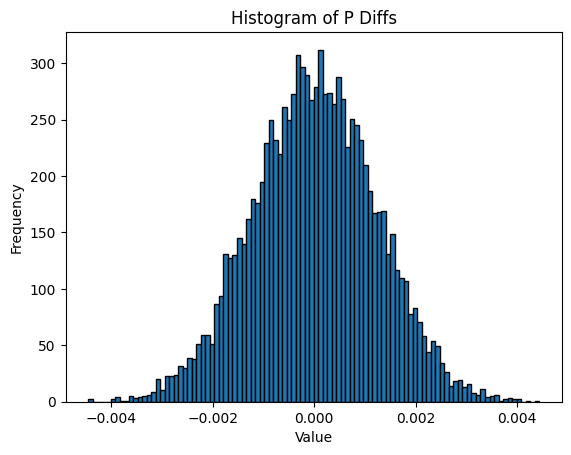

In [95]:
# YOUR CODE HERE
plt.hist(p_diffs, bins=100, edgecolor='black')

# Add labels and title
plt.title('Histogram of P Diffs')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [80]:
# save p_diffs for later use
# YOUR CODE HERE


The sample size of df2 is large enough that our sampling distribution is bell shaped. As we observed the actual difference in $(p_{new}-p_{old})$, based on the confidence interval, we have an equal difference in means between old and new pages. The normal distribution is small, that is, it's between (-0.05 and +0.05).

##### Exercise 10: What proportion of the $p_{diffs}$ are greater than the actual difference observed in ab_data.csv?

In [96]:
# YOUR CODE HERE
# Determine proportion of pdiffs > observed difference
new_page_df = df[df['landing_page'] == 'new_page']
new_page_converted_mean = new_page_df['converted'].mean()
old_page_df = df[df['landing_page'] == 'old_page']
old_page_converted_mean = old_page_df['converted'].mean()

actual_diff_from_dataset = new_page_converted_mean - old_page_converted_mean

counter = sum([i > actual_diff_from_dataset for i in p_diffs])

print (counter/(len(p_diffs)))


0.9017


In [98]:
# Calculate Z score with (p_new - p_old) / SE(P_diffs)
total_conv_prob = pvalue_converted_users
se_denom = (1 / n_new) + (1 / n_old)
standard_error = np.sqrt(total_conv_prob * (1 - total_conv_prob) * se_denom)

z_score = (new_page_converted_mean - old_page_converted_mean) / standard_error
z_score


-1.3109241984234394

##### Exercise 11: In words, explain what you just computed in Exercise 10.
What is this value called in scientific studies?

What does this value mean in terms of whether or not there is a difference between the new and old pages?

### **conclusion**

1. The z-critical value is 1.64
2. z-score (calculated) is -1.3109
3. We fail to reject the null hypothesis i.e. **the new page has a significant conversion rate more than the old page**

In [82]:
# What is this value called in scientific studies?
# Simulate distribution under the null hypothesis
# YOUR CODE HERE

# Plot the null distribution
# YOUR CODE HERE


In [99]:
# Compute p-value (consider h_alternative : p_new > p_old)
# YOUR CODE HERE
p_value = 1 - norm.cdf(z_score)
round(p_value, 4)


0.9051

**The actual difference is captured in the population. Since $p_{value}>0.05$, we would fail to reject the null hypothesis.**

100% of values from our null distribution fall to the right our actual difference. The old page has a higher probability of convertion rate than the new page.

##### Exercise 12: We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

Write your code in the below cells to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let $n_{old}$ and $n_{new}$ refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
# the number of conversions for each page
# YOUR CODE HERE

# the number of individuals who received each page
# YOUR CODE HERE


##### Exercise 13: Now use stats.proportions_ztest to compute your test statistic and p-value. Here is a helpful [link](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) on using the built in.

In [85]:
# YOUR CODE HERE


In [86]:
# print the z_score and p_value
# YOUR CODE HERE


In [87]:
from scipy.stats import norm
# Tells us how significant our z-score is?
# YOUR CODE HERE


In [88]:
# Tells us what our critical value at 95% confidence is?
# YOUR CODE HERE


##### Exercise 14: What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts Exercise 10 and Exercise 11?

#### **Your response here:**

**We would view various methods to conclude if $p_{new} = p_{old}$ or $p_{new} > p_{old}$:**

**Method-1: Binomial Proportion Confidence Intervals**

This method is quoted as the 'most common' method for A/B testing, where we find Confidence Intervals (CI) for both $p_{new}$ and $p_{old}$. If we construct similar intervals for both and compare them, we will end up in either scenario:

1. The Intervals do not overlap: This implies that we can say with some level of confidence that one is better than the other, therefore providing enough evidence to reject the Null Hypothesis. This level of confidence seems to be $≈ 1-e \alpha^{1.91}%$ (Lan, 2011). So if there is overlap and the 95% CI are the same size, the difference is significant at the 99.5% level.

2. The Intervals do overlap: Then it is either a sign that our population does not have enough statistical power, or we do not have enough evidence to reject the Null Hypothesis that $p_{new} = p_{old}$.

There is a relationship between CI comparisons and hypothesis tests - given that the sample sizes are not too different and the two sets have similar standard deviations.

Finding the 'true' conversion rate of a particular group is usually impossible or difficult, but we can use our calculated $p_{new}$ and $p_{old}$ as point estimations to find the Confidence Intervals for the 'true' $p_{new}$ and $p_{old}$.

In this context we define $CI_{new}$ and $CI_{old}$ as below.
* **$CI_{new}$:** The confidence interval $CI_{new}$ represents the range of values within which we estimate the true conversion rate $p_{new}$ of the new group lies with 95% confidence.

* **$CI_{old}$:** The confidence interval $CI_{old}$ represents the range of values within which we estimate the true conversion rate $p_{old}$ of the old group lies with 95% confidence.

Exercise 1: Define a customized function **get_z_score()** to get the z-score. Consider $\alpha = 5$% (0.5 point)

**Hint:** You can use the inverse cumulative distribution function (CDF) of the standard normal distribution [i.e., scipy.stats.norm.ppf() in Python] to find the z-score

In [89]:
#function for getting z-scores for alpha. For our experiemnt where alpha = 5%, keep in mind we want to input 1-alpha/2 for Confidence Intervals.
# YOUR CODE HERE


Exercise 2 **(Optional)**: Now calculate the $CI_{old}$ and $CI_{new}$ using the **get_z_score** and given $\alpha = 5$% (0.5 point)

In [90]:
# check whether Confidence Interval old (CI_old) & Confidence Interval new (CI_new) overlap?
# YOUR CODE HERE


Both CI intervals overlap plenty as $CI_{new}$ is completely contained within $CI_{old}$ , which means we do not reject the Null Hypothesis that $p_{new} = p_{old}$.

    This means that the new page is not better than the old page.

While our case is quite evident that the overlap is significantly clear, slight overlaps could tempt us to draw the same conclusion to reject the Null Hypothesis. However, this is a common misinterpretation of overlapping CIs when comparing groups. Failure to do so could result in incorrect or misleading conclusions being drawn (Tan & Tan, 2010, pp. 278).

**Method-2: Z-test**

We can use existing packages to calculate our test statistic and p-values and test for proportions based on the **z-test.** This is similar to the Binomial Proportion Confidence Interval Test, is quantitatively easier to draw conclusions out of due to it returning a p-value:

Exercise 1: Calculate the total number of conversions for each group (convert_old & convert_new) (0.5 point)

**Hints:**
* Use the condition ("landing_page == 'old_page' and converted == 1") for calculating convert_old
* Use the condition ("landing_page == 'new_page' and converted == 1") for calculating convert_new

In [91]:
#returning the total number of conversions for each group: (convert_old & convert_new)
# YOUR CODE HERE


Exercise 2: Calculate the z_score and p_value using the one-sided z-test (0.5 point)

In [92]:
#calculating the z-score + p-value using the z-test (one-sided):
# YOUR CODE HERE


Given our **p-value ≈ 0.9 > 0.05**, we do not reject the Null Hypothesis.

    This means that the new page is not better than the old page.

**Method-3: Chi-Squared Test**

One statistical test that came out is the Chi-Squared Analysis (or $\chi^{2}$ test). If we constructed a 2x2 contingency table for our observed frequencies in our dataset, and compared it to a 2x2 contingency table for the expected frequencies in our dataset, we can perform the $\chi^{2}$ test under the Null Hypothesis that there is no relationship that exists on between our conversion vs their treatment/control group in the population.

For reference, our 2x2 contingency table will have two groups: treatment/control or converted/not converted. We want to make 4 calculations that will be in our table:
1. Treatment, converted
2. Treatment, not converted
3. Control, converted
4. Control, not converted

Exercise 1: (0.5 point)
* Calculate the 4 entities (treatment_converted, treatment_not_converted, control_converted & control_not_converted)
* Create the 2x2 Contingency table which will be required to do the Chi-Square test

In [93]:
# Do the 4 calculations as above:
# YOUR CODE HERE

# create the array to do our chi-squared test: treatment/control along the rows and converted/not converted along the columns:
# YOUR CODE HERE


Exercise 2: Carry out the Chi-Square test and estimate the p-value (0.5 point)

In [94]:
# using scipy stats to perform our chi squared test:
# YOUR CODE HERE


**Give your remarks here on the results achieved from Chi-Square Test.**

**Conclusion:**

The A/B testing experiment was designed to determine if <b>FaceZonGoogAppFlix</b>'s new webpage would improve the conversion rate of their users compared to their existing one.

After going through multiple statistical methods to determine a winner of the A/B test, We've seen that <b>FaceZonGoogAppFlix</b>'s underlying goal had not been reached with their new webpage.

Hence, we recommend that to not continue with the new webpage change, but pursue other strategies & experiments.